[<img src="../XRO_logo.png" width="500">](https://github.com/senclimate/XRO) 

Author: Sen Zhao <zhaos@hawaii.edu>

In this notebook, we will demonstrate how to fit, simulate and reforecast ENSO with the python `XRO` library.

1) XRO fitting on observation 
3) XRO stochastic simulation
4) XRO determintic reforecasting
5) XRO stochastic reforecasting

This examples may be executed within 5 minutes in a personal computer.

See our paper Zhao et al. 2024[[1]](#1) for details of analysis. If you encounter problems in running `XRO`, please feel free to contact Sen Zhao (zhaos@hawaii.edu).

<a id="1">[1]</a> 
Zhao, S., Jin, F.-F., Stuecker, M.F., Thompson, P.R., Kug, J.-S., McPhaden, M.J., Cane, M.A., Wittenberg, A.T., Cai, W.,. Explainable El Niño predictability from climate mode interactions. Nature.


## Libraries

Include libraries for both computing and visualization

In [1]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

import datetime
from dateutil.relativedelta import *

import numpy as np
import xarray as xr

from climpred import HindcastEnsemble

from XRO import XRO

## XRO models in different complexities

Here we include two versions of XRO model:

    - XRO model with annual mean, annual cycle, and semi-annual cycles components (XROac2)
    - XRO model with annual mean component only (XROac0)

Notes:
1. The monthly time series is used to train the XRO model, so we set `ncycle=12`. Therefore, the XRO simulate/reforecast output is also monthly mean time series.
2. It should be noted that the XRO accept higher resolution data such as (ncycle=52 for weekly data and ncycle=365 for daily data), similarly the output of simulate/reforecast will be weakly or daily automatically.


In [2]:
# XRO model with annual mean, annual cycle, and semi-annual cycle
XROac2 = XRO(ncycle=12, ac_order=2)

# XRO model without annual cycles
XROac0 = XRO(ncycle=12, ac_order=0)

## XRO data prepration

Following Zhao et al. (2024), the standard XRO include the state vectors of ENSO and other climate modes in global oceans.
which includes $X_{ENSO}=[T_{ENSO}, WWV]$ and $X_M=[T_{NPMM},T_{SPMM},T_{IOB},T_{IOD},T_{SIOD},T_{TNA},T_{ATL3},T_{SASD}]$, respectively.

See the defitions of those SST and WWV indices from Zhao et al. (2024). For briefty, here we use the observed indices from ORAS5 reanalysis for 1979-2023 as an exmaple.



<xarray.Dataset>
Dimensions:  (time: 538)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-10-01
    month    (time) int64 ...
Data variables:
    Nino34   (time) float64 ...
    WWV      (time) float64 ...
    NPMM     (time) float64 ...
    SPMM     (time) float64 ...
    IOB      (time) float64 ...
    IOD      (time) float64 ...
    SIOD     (time) float64 ...
    TNA      (time) float64 ...
    ATL3     (time) float64 ...
    SASD     (time) float64 ...


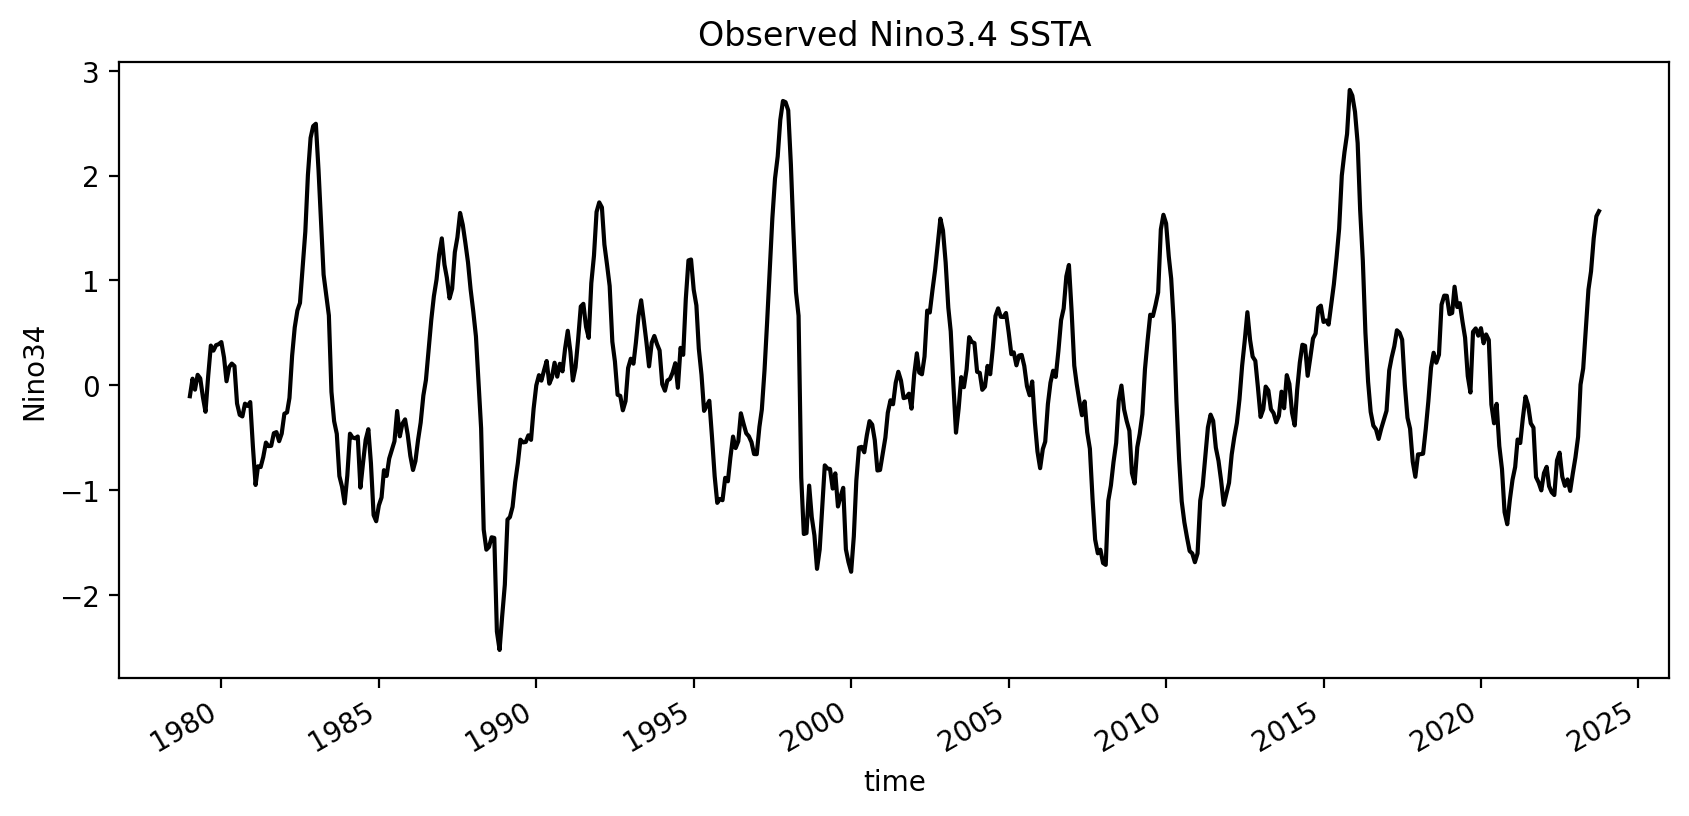

In [3]:
# load observed state vectors of XRO: which include ENSO, WWV, and other modes SST indices
# the order of variables is important, with first two must be ENSO SST and WWV;
obs_ds = xr.open_dataset('../data/indices_oras5.nc').rename({'Hm': 'WWV', 'SASD1': 'SASD'})
print(obs_ds)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
obs_ds['Nino34'].plot(ax=ax, c='black', )
ax.set_title('Observed Nino3.4 SSTA')


# select 1979-01 to 2022-12 as training data
train_ds = obs_ds.sel(time=slice('1979-01', '2022-12'))

## XRO training

The XRO model form : dX/dt = L * X + maskb * Ib * X^2 + X * X(1) * maskth
 - maskb and n_th is determining the form of nonlinear form
 - maskb : quadratic nonlinear terms for each equation of the names in maskb, while n_th=1 : T*H in ENSO SST equation

**XRO equation forms**

- The standard XRO model in Zhao et al. (2024) is maskb for ENSO's SST and IOD's SST and T*H term in ENSO SST equation, thus `maskb=['Nino34', 'IOD']`, `n_th=1`
- The linear form of XRO is setting `maskb=[]` and `n_th=0`

In [4]:
# XRO model used as control experiment in the paper
XROac2_fit = XROac2.fit_matrix(train_ds, maskb=['Nino34', 'IOD'], n_th=1)
print('XRO control model parameters')
print(XROac2_fit)

# XRO ac=0 model
XROac0_fit = XROac0.fit_matrix(train_ds, maskb=['Nino34', 'IOD'], n_th=1)
print('XRO(ac=0) model parameters')
print(XROac0_fit)

XRO control model parameters
<xarray.Dataset>
Dimensions:         (ranky: 10, rankx: 10, cycle: 12, ac_rank: 3, cossin: 5,
                     time: 528, ranky_ro: 1)
Coordinates:
  * ranky           (ranky) int64 1 2 3 4 5 6 7 8 9 10
  * rankx           (rankx) int32 1 2 3 4 5 6 7 8 9 10
  * cycle           (cycle) float64 0.04167 0.125 0.2083 ... 0.7917 0.875 0.9583
  * ac_rank         (ac_rank) int32 0 1 2
  * cossin          (cossin) int32 0 1 2 3 4
  * time            (time) float64 0.04167 0.125 0.2083 ... 43.79 43.88 43.96
  * ranky_ro        (ranky_ro) int64 1
Data variables: (12/25)
    Lac             (ranky, rankx, cycle) float64 -2.244 -2.184 ... -2.322
    Lcomp           (ranky, rankx, cycle, ac_rank) float64 -0.8431 ... -0.2386
    Lcoef           (ranky, rankx, cossin) float64 -0.8431 -0.8744 ... 0.8181
    X               (rankx, time) float64 -0.1045 0.06282 ... 0.07346 0.02704
    Y               (ranky, time) float64 2.008 -1.254 1.694 ... -0.5571 -0.5571
    Yfit 

## XRO stochastic simulation

stochastic simulation (as an example, initial from observed 1979-01, each model run 100 years with 100 realiazations)

- set `seed` to int number to get the exact same result (default is None)
- set `is_xi_stdac=True` if consider seasonal modulation of noise amplitde (default is None)

The output is archived as monthly mean of state vectors


In [5]:
XROac2_sim = XROac2.simulate(fit_ds=XROac2_fit, X0_ds=train_ds.isel(time=0), nyear=100, ncopy=100, is_xi_stdac=True)  
print('XRO control stochastic simulation')
print(XROac2_sim)

XROac0_sim = XROac0.simulate(fit_ds=XROac0_fit, X0_ds=train_ds.isel(time=0), nyear=100, ncopy=100)  #set seed=1000 to get the exact same result
print('XRO(ac=0) model stochastic simulation')
print(XROac0_sim)

XRO control stochastic simulation
<xarray.Dataset>
Dimensions:  (time: 1200, member: 100)
Coordinates:
  * time     (time) object 0001-01-01 00:00:00 ... 0100-12-01 00:00:00
  * member   (member) int32 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
Data variables:
    Nino34   (time, member) float64 -0.02581 -0.04567 -0.2053 ... 1.146 -1.048
    WWV      (time, member) float64 11.9 11.5 9.843 ... -0.2716 5.115 -9.461
    NPMM     (time, member) float64 -0.4445 -0.2261 -0.2785 ... -0.2069 -0.1535
    SPMM     (time, member) float64 0.5108 0.6659 0.4302 ... 0.3916 0.2546
    IOB      (time, member) float64 0.1949 0.1419 0.2207 ... 0.2257 -0.07878
    IOD      (time, member) float64 0.3814 0.4267 0.1591 ... 0.3448 -0.132
    SIOD     (time, member) float64 -0.02583 0.2818 0.09968 ... 0.2605 0.07755
    TNA      (time, member) float64 0.3564 0.4149 0.3001 ... -0.01004 0.0298
    ATL3     (time, member) float64 -0.2231 -0.04606 -0.2161 ... 0.06396 0.2917
    SASD     (time, member) floa

### Simulating Metric Exmaple 1: ENSO irregular interannual oscillations in XRO
Show the time series of each member

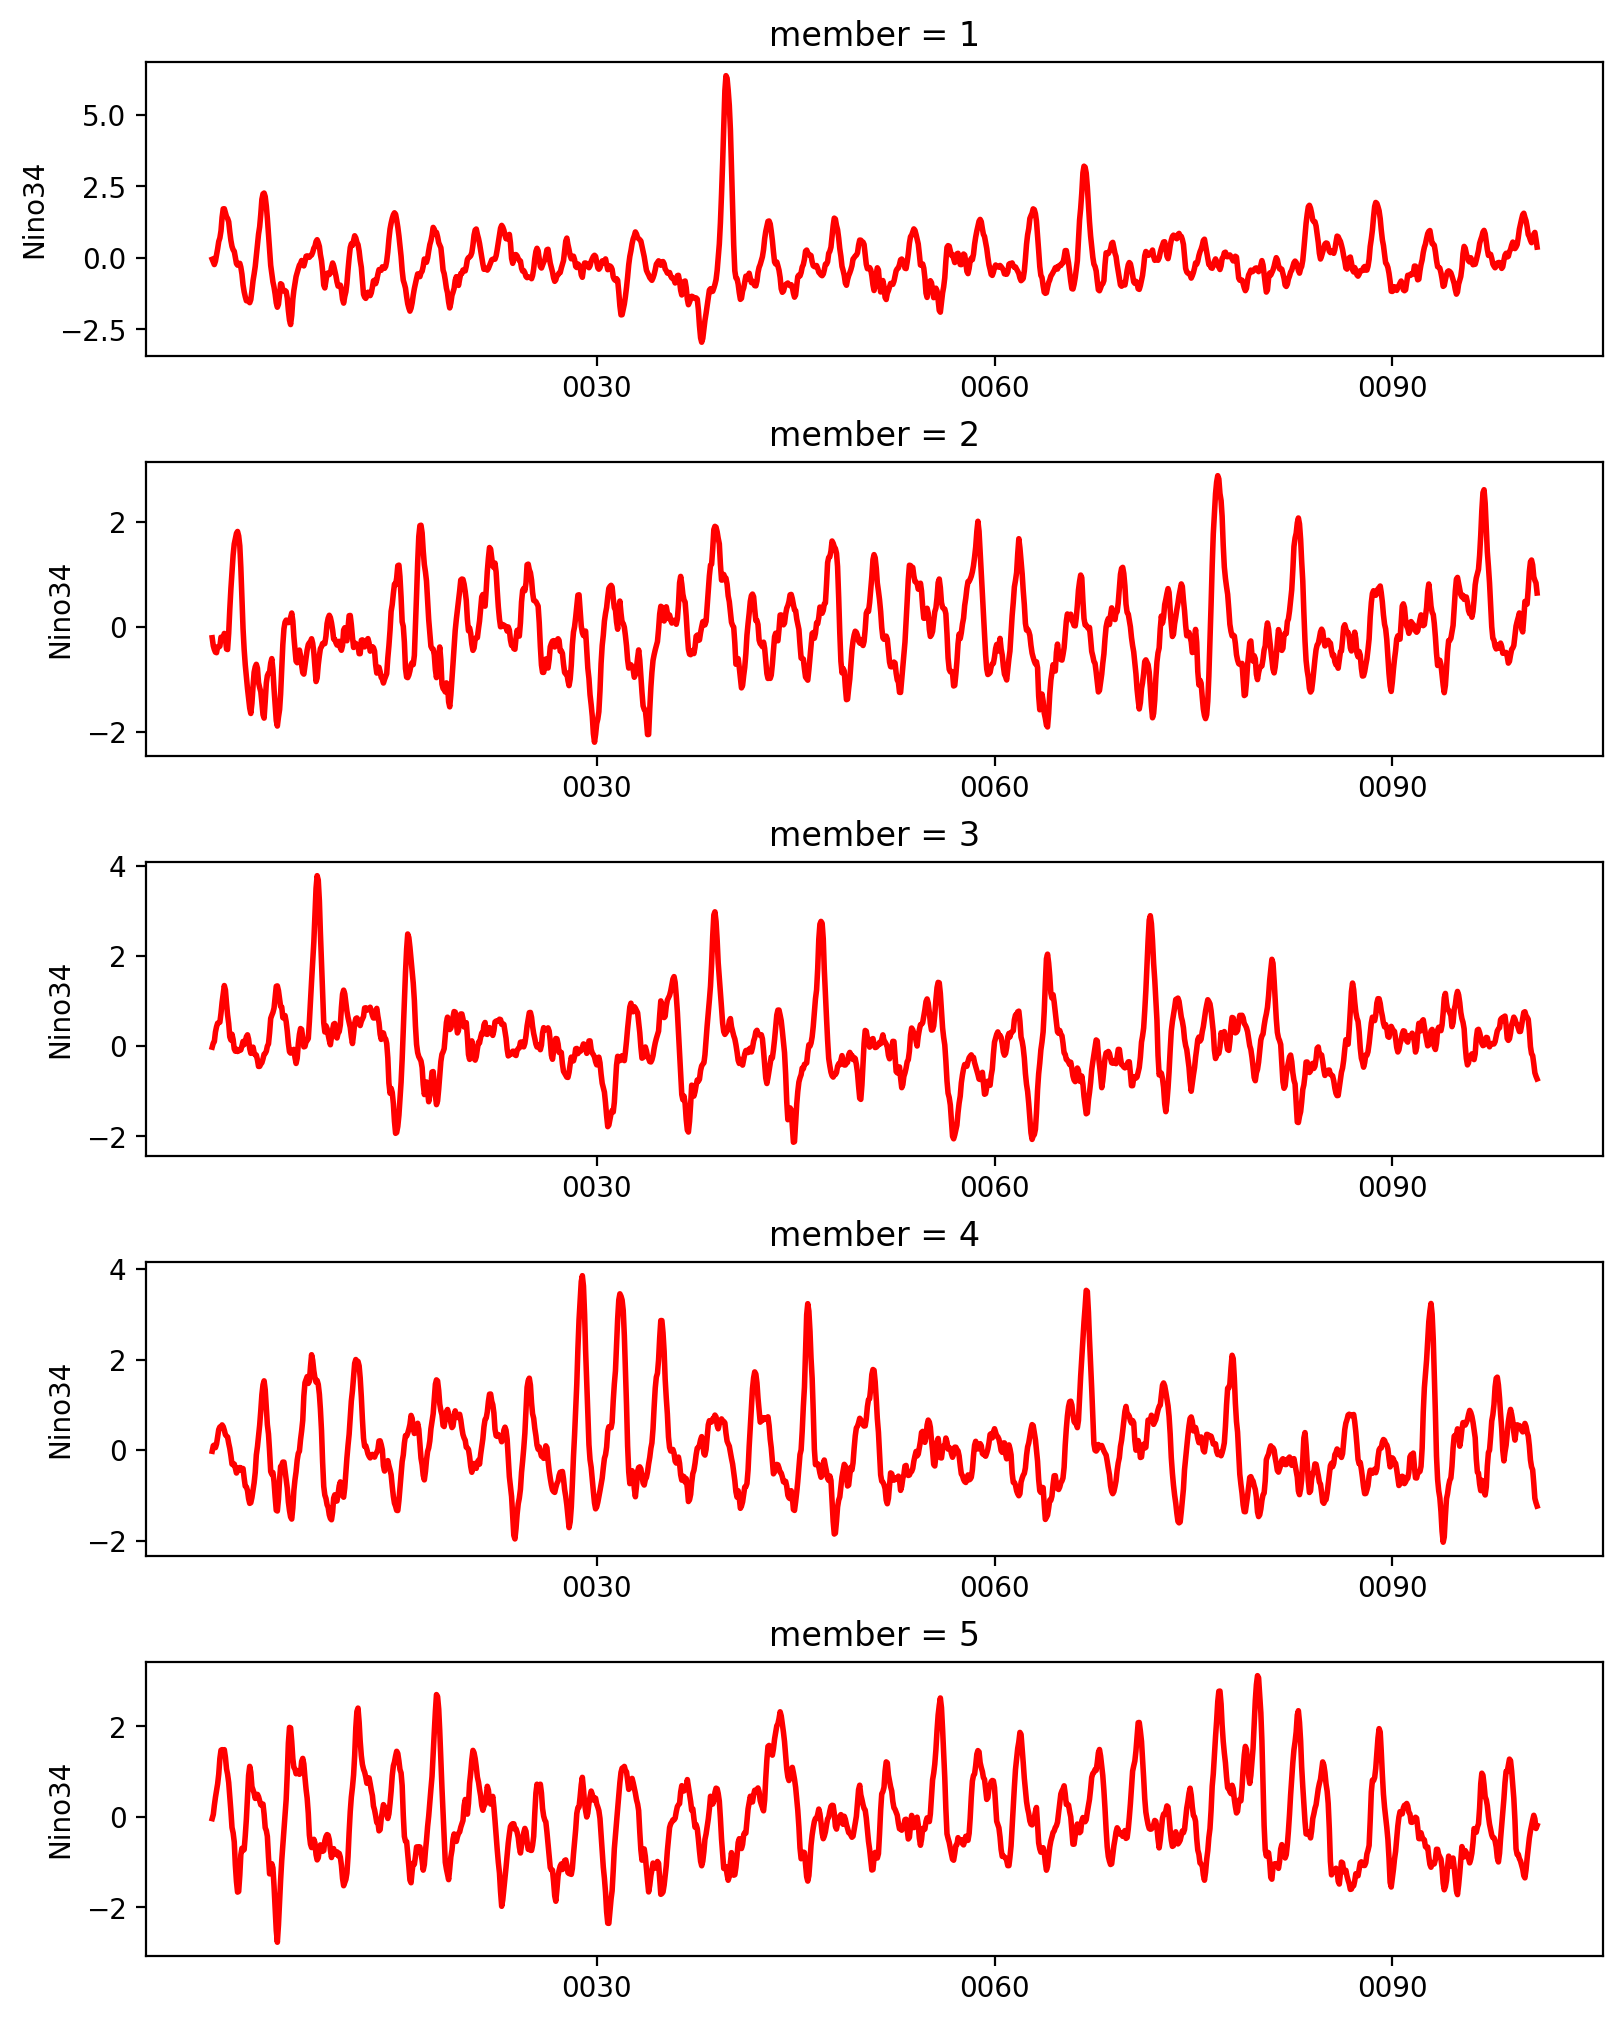

In [6]:
nmember=5
fig, axes = plt.subplots(nmember, 1, figsize=(8, nmember*2), layout='compressed')

for i, ax in enumerate(axes.flat):
    XROac2_sim.isel(member=i+1)['Nino34'].plot(ax=ax, c='r', lw=2)
    ax.set_xlabel('')

### Simulating Metric Exmaple 2: ENSO seasonal synchronization example

In the following code block, we calcualte the Nino34 seasonal standard deviation (stddev) for observation (ORAS5), XRO control simulation, and XRO(ac=0) simulation.

- As shown in the figure, XRO accurately simulates observed ENSO seasonal synchronization (comoare black curve and red curve)
- If we don't include the seasonal cycle in the XRO operators, there is no seasonal synchronization (blue curve)


Text(0.5, 1.0, 'XRO accurately simulates ENSO seasonal synchronization')

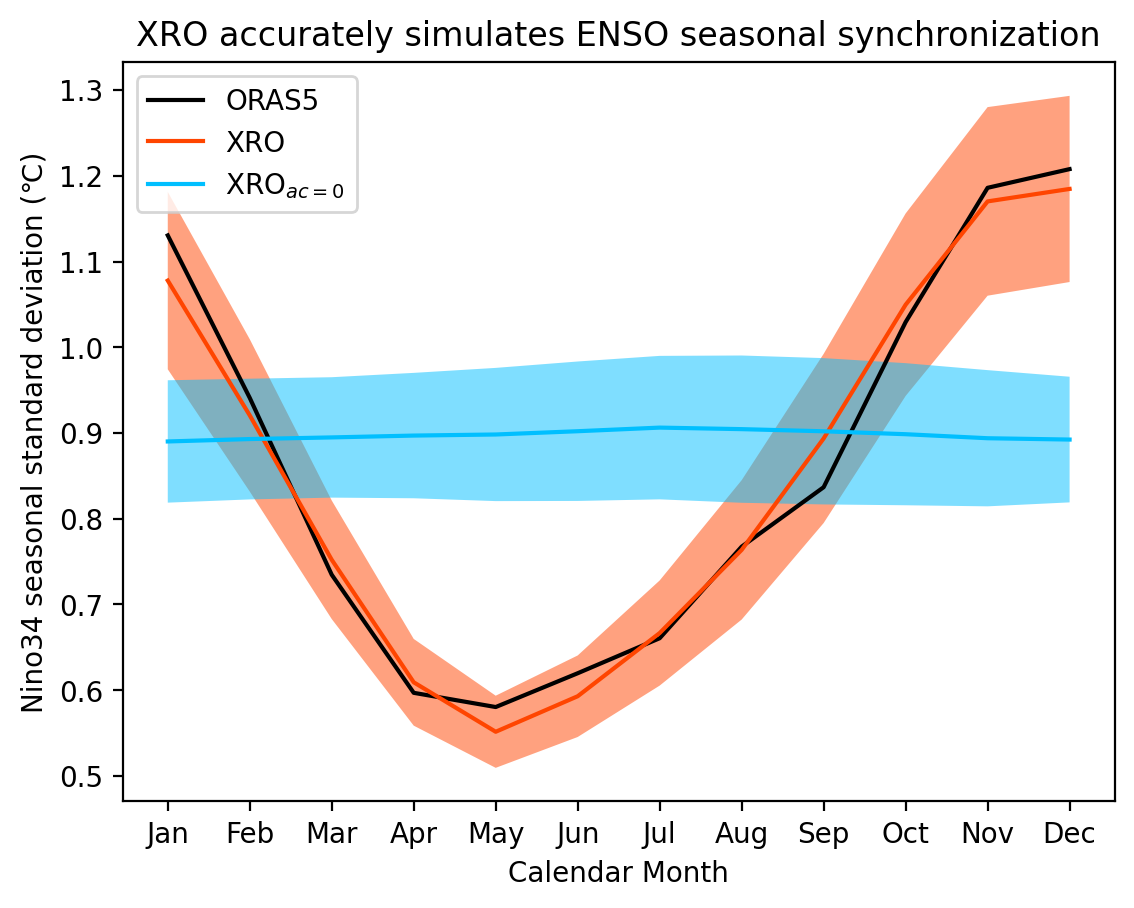

In [7]:
# as exmaple shown the 
stddev_obs = train_ds.groupby('time.month').std('time')

stddev_XROac2 = XROac2_sim.groupby('time.month').std('time')
stddev_XROac2_m = stddev_XROac2.mean('member')
stddev_XROac2_e = stddev_XROac2.std('member')

stddev_XROac0 = XROac0_sim.groupby('time.month').std('time')
stddev_XROac0_m = stddev_XROac0.mean('member')
stddev_XROac0_e = stddev_XROac0.std('member')

sel_var = 'Nino34'
plt.plot(stddev_obs.month, stddev_obs[sel_var], c='black', label='ORAS5')
plt.plot(stddev_XROac2_m.month, stddev_XROac2_m[sel_var], c='orangered', label='XRO')
plt.fill_between(stddev_XROac2_m.month, (stddev_XROac2_m-stddev_XROac2_e)[sel_var], (stddev_XROac2_m+stddev_XROac2_e)[sel_var], fc='orangered', alpha=0.5)
plt.plot(stddev_XROac0_m.month, stddev_XROac0_m[sel_var], c='deepskyblue', label='XRO$_{ac=0}$')
plt.fill_between(stddev_XROac0_m.month, (stddev_XROac0_m-stddev_XROac0_e)[sel_var], (stddev_XROac0_m+stddev_XROac0_e)[sel_var], fc='deepskyblue', alpha=0.5)
plt.legend()
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Nino34 seasonal standard deviation (℃)')
plt.xlabel('Calendar Month')
plt.title('XRO accurately simulates ENSO seasonal synchronization')


## XRO reforecasting

reforecasting (as an example, initial from observed 1979-01 to 2023-10, each run 21 months)
- `fit_ds` is the trained operators, in which linear/nonlinear operators `Lac`/`NLac` as well as noise parameters `xi_std` and `xi_a1` will be used
- `init_ds` is initial condictions, the order of variables has been the same with the trained parameters
- determinsitc forecast by setting `noise_type='zero'` 
- stochastic forecast by setting `noise_type='red'` and `ncopy=100` (100 members)


In [8]:
XROac0_fcst = XROac0.reforecast(fit_ds=XROac0_fit, init_ds=obs_ds, n_month=21, ncopy=1, noise_type='zero')
XROac0_fcst

XROac2_fcst = XROac2.reforecast(fit_ds=XROac2_fit, init_ds=obs_ds, n_month=21, ncopy=1, noise_type='zero')
print(XROac2_fcst)

<xarray.Dataset>
Dimensions:  (lead: 22, init: 538)
Coordinates:
  * lead     (lead) int32 0 1 2 3 4 5 6 7 8 9 ... 12 13 14 15 16 17 18 19 20 21
  * init     (init) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-10-01
    month    (init) int64 ...
Data variables:
    Nino34   (init, lead) float64 -0.1045 -0.07647 -0.05089 ... -0.6957 -0.6088
    WWV      (init, lead) float64 10.41 10.02 9.24 ... -0.5084 0.6822 1.369
    NPMM     (init, lead) float64 -0.2496 -0.2727 -0.3006 ... -0.2943 -0.3039
    SPMM     (init, lead) float64 0.5032 0.4643 0.4158 ... -0.1784 -0.1871
    IOB      (init, lead) float64 0.2056 0.1623 0.09626 ... -0.2444 -0.225
    IOD      (init, lead) float64 0.4423 0.3407 0.1832 ... -0.02997 -0.05956
    SIOD     (init, lead) float64 0.3092 0.2644 0.2025 ... -0.2089 -0.1996
    TNA      (init, lead) float64 0.2763 0.3251 0.3859 ... -0.1165 -0.08901
    ATL3     (init, lead) float64 -0.1592 -0.1696 -0.1694 ... 0.2723 0.3103
    SASD     (init, lead) float64 0.1024 0.1915 0

### forecast skill performance using `climpred`


In [9]:
def calc_forecast_skill(fcst_ds, ref_ds, metric='acc', is_mv3=True, comparison="e2o", 
                        by_month=False, verify_periods=slice('1979-01', '2022-12')):
    try:
        fcst_ds = fcst_ds.squeeze().drop('member')
    except:
        pass

    if is_mv3:
        fcst_ds = fcst_ds.rolling(init=3, center=True, min_periods=1).mean('init')
        ref_mv3 = ref_ds.rolling(time=3, center=True, min_periods=1).mean().dropna(dim='time')
    else:
        ref_mv3 = ref_ds

    hc_XRO = HindcastEnsemble(fcst_ds.sel(init=verify_periods))
    hc_XRO = hc_XRO.add_observations(ref_mv3)
    if by_month:
        skill_XRO = hc_XRO.verify(metric=metric, comparison=comparison, alignment="maximize", dim=["init"], skipna=True, groupby='month')
    else:
        skill_XRO = hc_XRO.verify(metric=metric, comparison=comparison, alignment="maximize", dim=["init"], skipna=True)
    try:
        del skill_XRO.attrs['skipna']
        skill_XRO = skill_XRO.drop('skill')
    except:
        pass

    for var in skill_XRO.data_vars:
        if var != 'model':
            skill_XRO[var].encoding['dtype'] = 'float32'
            skill_XRO[var].encoding['_FillValue'] = 1e20
    return skill_XRO

### correlation skill
In-sample correlation skill of XRO and XRO(ac=0) for 1979-2022

In [10]:
acc_XROac0 = calc_forecast_skill(XROac0_fcst, obs_ds, metric='acc', is_mv3=True, by_month=False, verify_periods=slice('1979-01', '2022-12'))
acc_XROac0

acc_XROac2 = calc_forecast_skill(XROac2_fcst, obs_ds, metric='acc', is_mv3=True, by_month=False, verify_periods=slice('1979-01', '2022-12'))
print(acc_XROac2)

<xarray.Dataset>
Dimensions:  (lead: 22)
Coordinates:
  * lead     (lead) int32 0 1 2 3 4 5 6 7 8 9 ... 12 13 14 15 16 17 18 19 20 21
Data variables:
    Nino34   (lead) float64 1.0 0.9884 0.9694 0.9449 ... 0.5016 0.4565 0.4122
    WWV      (lead) float64 1.0 0.9885 0.9702 0.9484 ... 0.4686 0.431 0.4006
    NPMM     (lead) float64 1.0 0.9739 0.9203 0.8647 ... 0.5312 0.4943 0.4579
    SPMM     (lead) float64 1.0 0.9534 0.8533 0.7394 ... 0.1068 0.09278 0.08248
    IOB      (lead) float64 1.0 0.9649 0.9053 0.8515 ... 0.5424 0.5249 0.5083
    IOD      (lead) float64 1.0 0.9345 0.8163 0.6978 ... 0.1937 0.1725 0.1425
    SIOD     (lead) float64 1.0 0.9511 0.8602 0.7722 ... 0.4131 0.3505 0.2868
    TNA      (lead) float64 1.0 0.9593 0.8724 0.7766 ... 0.2125 0.2205 0.2265
    ATL3     (lead) float64 1.0 0.9373 0.8085 0.6682 ... 0.2998 0.2991 0.3027
    SASD     (lead) float64 1.0 0.9259 0.7857 0.6602 ... 0.3652 0.3454 0.3319
Attributes:
    prediction_skill_software:     climpred https://climp

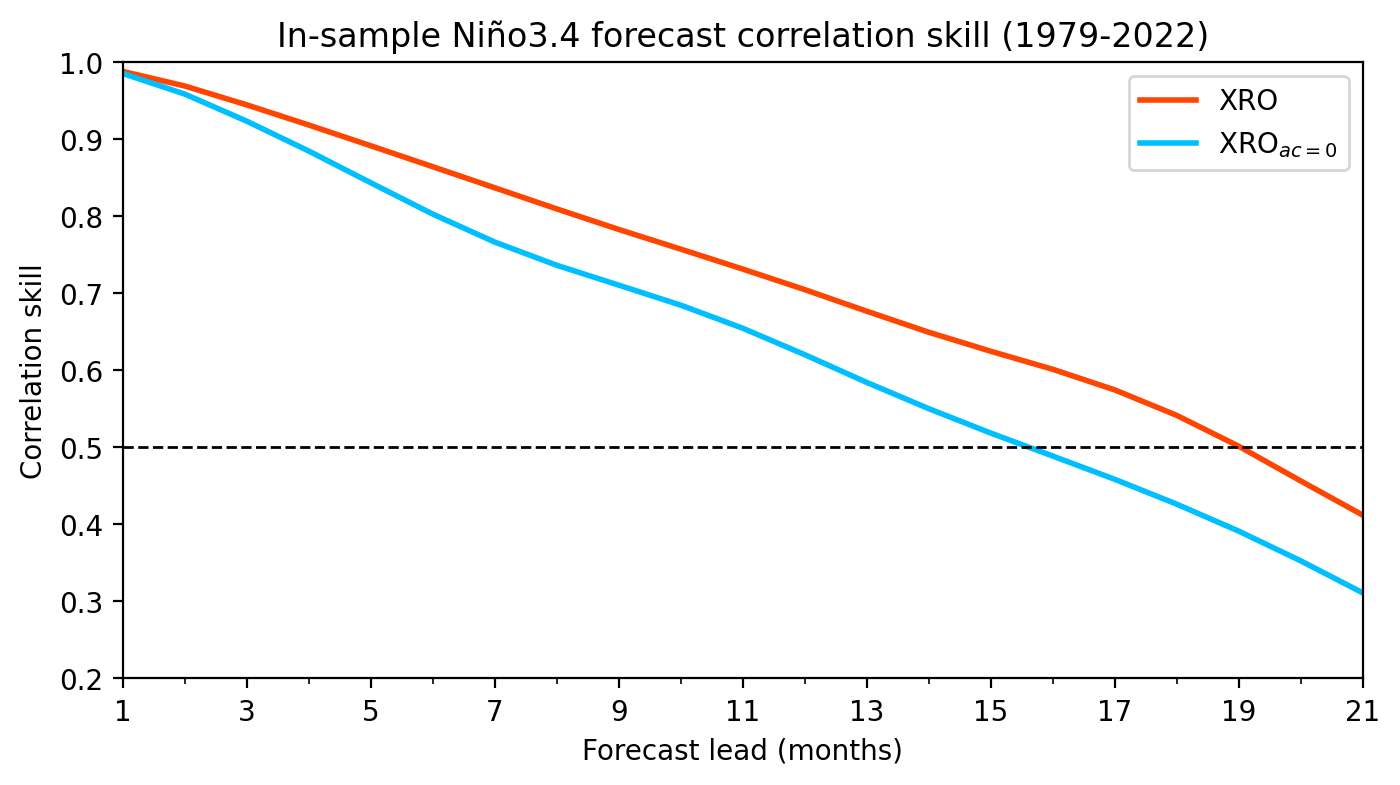

In [11]:
sel_var = 'Nino34'
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
acc_XROac2[sel_var].plot(ax=ax, label='XRO', c='orangered', lw=2)
acc_XROac0[sel_var].plot(ax=ax, label='XRO$_{ac=0}$', c='deepskyblue', lw=2)

ax.set_ylabel('{0} skill'.format('Correlation') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0.2, 1.])
ax.set_xlim([1., 21])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample Niño3.4 forecast correlation skill (1979-2022)')
ax.legend()

### RMSE skill

In-sample RMSE skill of XRO and XRO(ac=0) for 1979-2022

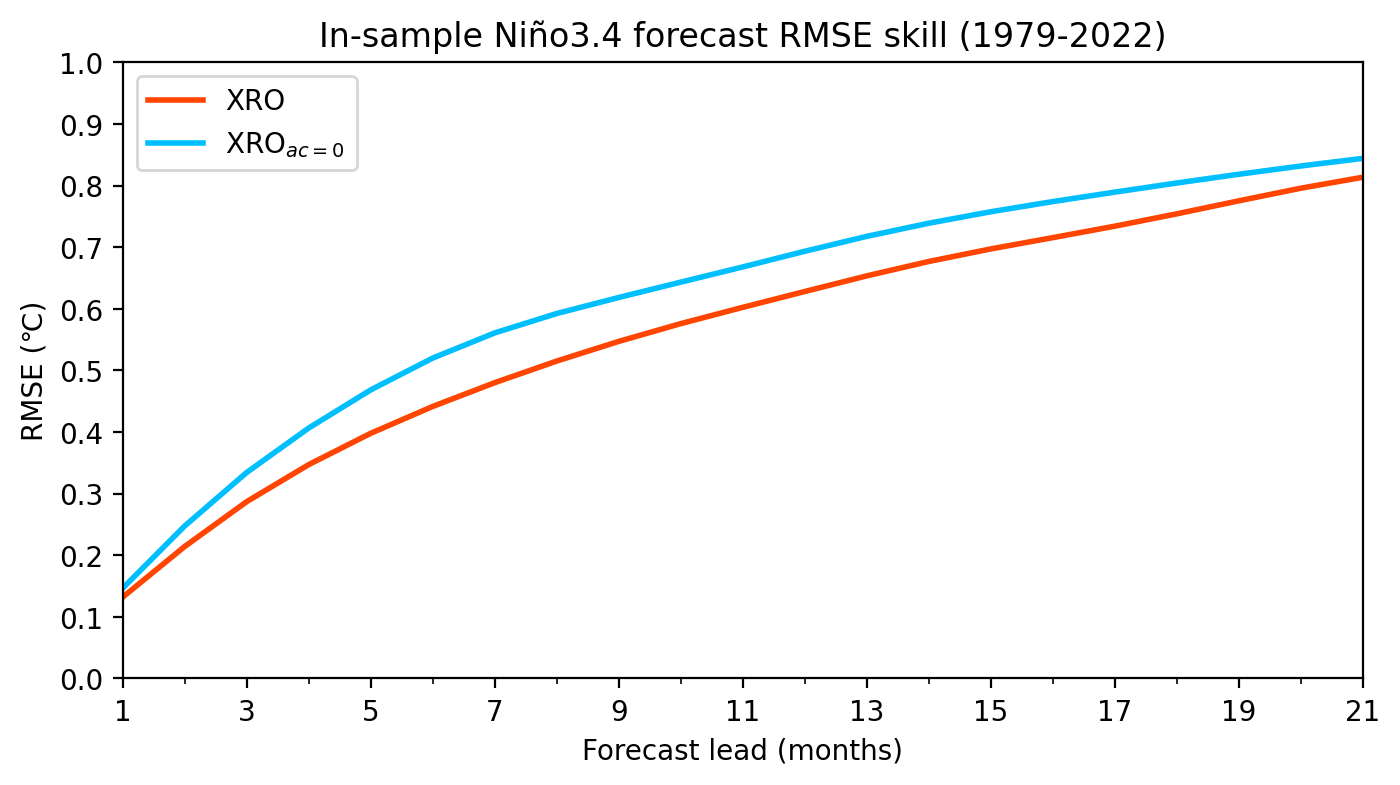

In [12]:
rmse_XROac0 = calc_forecast_skill(XROac0_fcst, obs_ds, metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('1979-01', '2022-12'))
rmse_XROac0

rmse_XROac2 = calc_forecast_skill(XROac2_fcst, obs_ds, metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('1979-01', '2022-12'))
rmse_XROac2

sel_var = 'Nino34'
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
rmse_XROac2[sel_var].plot(ax=ax, label='XRO', c='orangered', lw=2)
rmse_XROac0[sel_var].plot(ax=ax, label='XRO$_{ac=0}$', c='deepskyblue', lw=2)

ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 21])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample Niño3.4 forecast RMSE skill (1979-2022)')
ax.legend()

## XRO stochastic reforecasting
 - stochastic forecast by setting `noise_type='red'` and `ncopy=100` (100 members)

It will take a while since you have 100 members, of course you can reduce the member size 

In [13]:
XROac2_fcst_stoc = XROac2.reforecast(fit_ds=XROac2_fit, init_ds=obs_ds, n_month=21, ncopy=100, noise_type='red')
print(XROac2_fcst_stoc)

<xarray.Dataset>
Dimensions:  (lead: 22, member: 100, init: 538)
Coordinates:
  * lead     (lead) int32 0 1 2 3 4 5 6 7 8 9 ... 12 13 14 15 16 17 18 19 20 21
  * member   (member) int32 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * init     (init) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-10-01
    month    (init) int64 ...
Data variables:
    Nino34   (init, lead, member) float64 -0.1045 -0.1045 ... -0.3785 -0.395
    WWV      (init, lead, member) float64 10.41 10.41 10.41 ... -5.638 -2.859
    NPMM     (init, lead, member) float64 -0.2496 -0.2496 ... -0.09249 -0.2255
    SPMM     (init, lead, member) float64 0.5032 0.5032 ... 0.04283 0.1406
    IOB      (init, lead, member) float64 0.2056 0.2056 ... -0.1136 -0.2856
    IOD      (init, lead, member) float64 0.4423 0.4423 ... -0.2209 -0.2614
    SIOD     (init, lead, member) float64 0.3092 0.3092 ... -0.4296 0.2582
    TNA      (init, lead, member) float64 0.2763 0.2763 ... -0.7087 -0.5539
    ATL3     (init, lead, member)

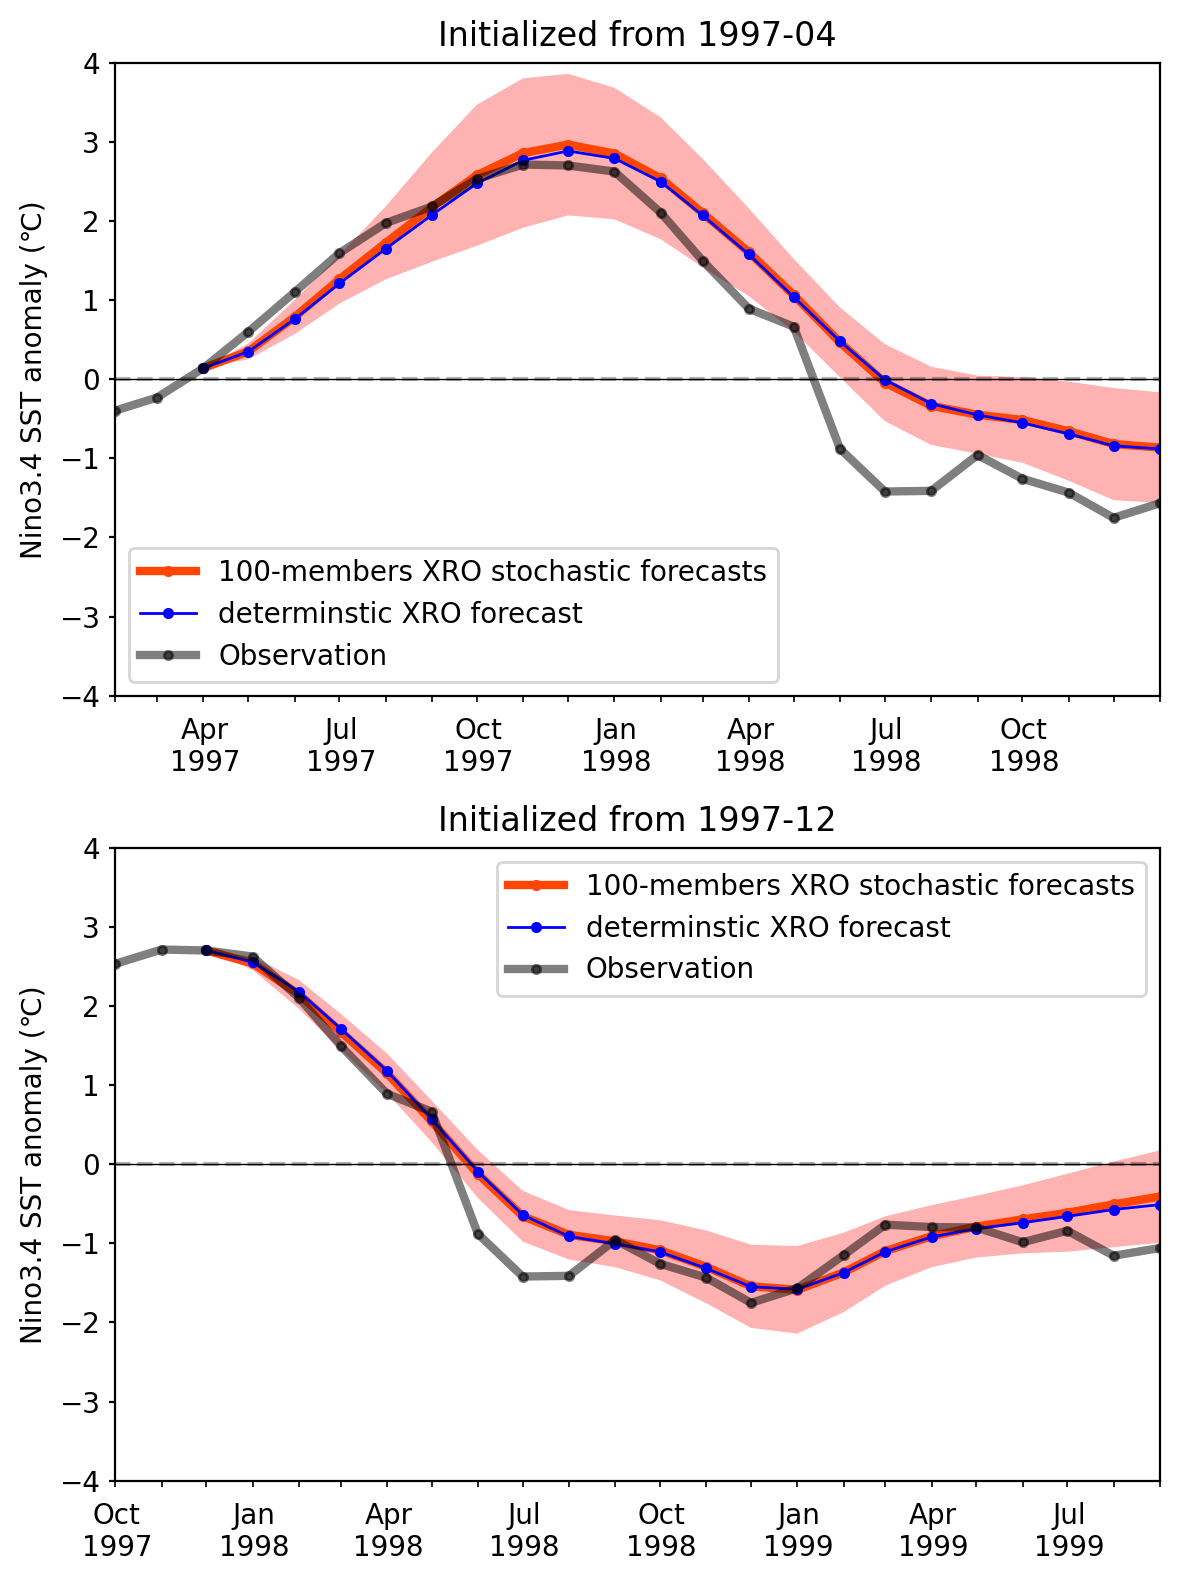

In [14]:
date_arrs = ['1997-04', '1997-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_d = XROac2_fcst['Nino34'].sel(init=sel_date).squeeze()
    sel_fcst_m = XROac2_fcst_stoc['Nino34'].sel(init=sel_date).mean('member').squeeze()
    sel_fcst_e = XROac2_fcst_stoc['Nino34'].sel(init=sel_date).std('member').squeeze()
    nlead = len(sel_fcst_m.lead)
    
    xdate_mid = datetime.datetime.strptime(sel_date+'-01', "%Y-%m-%d").date()
    xdate_strt = datetime.datetime.strptime(sel_date+'-01', "%Y-%m-%d").date() + relativedelta(months=-2)
    xdate_last = datetime.datetime.strptime(sel_date+'-01', "%Y-%m-%d").date() + relativedelta(months=nlead-1)
    
    sel_obs = obs_ds['Nino34'].sel(time=slice(xdate_strt, xdate_last))
    xtime = sel_obs.time
    xtime_fcst = xtime[2:]
    
    ax.plot(xtime_fcst, sel_fcst_m, c='orangered', marker='.', lw=3, label='100-members XRO stochastic forecasts')

    ax.fill_between(xtime_fcst,sel_fcst_m-sel_fcst_e, sel_fcst_m + sel_fcst_e, fc='red', alpha=0.3, ) #label='100-members stochastic forecasts'
    ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='determinstic XRO forecast' )
    ax.plot(xtime, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5 )

    ax.axhline(y=0., c = 'black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator( interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))
    # ax.set_xticklabels(xdate_minorticks , minor=True,) 

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])
    
    ax.set_title("Initialized from {0}".format(sel_date))
    # ax.set_xlim([1980, 2025])
    ax.set_ylim([-4., 4.])
    ax.set_ylabel('Nino3.4 SST anomaly (℃)')
    ax.axhline(0, c='k', ls='--', alpha=0.3)
    ax.legend()

fig.tight_layout()
